# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [9]:
import citipy.citipy as citipy, matplotlib.pyplot as plt, numpy as np, pandas as pd, requests, random
from scipy.stats import linregress
from api_keys import weather_api_key

In [7]:
def get_random_floats(low, high, k=1):
    """ Return a unique random floats
        in the range of low <= x <= high
    """
    result = []
    seen = set()
    for i in range(k):
        x=random.uniform(low, high)
        while x in seen:
            x=random.uniform(low, high)
        seen.add(x)
        result.append(x)
    return result

def get_random_lat():
    return random.uniform(-90, 90)

def get_random_lon():
    return random.uniform(-180, 180)

def generate_city_response(city_name):
    url=f"http://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={weather_api_key}&units=imperial"
    return requests.get(url).json()

def print_city(num,city_name):
    print (f"Processing record {(num+1)%50} of set {round((num+1)/50)+1} | {city_name.capitalize()}")

def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.5)

# 75th Percentile
def q75(x):
    return x.quantile(0.75)

def scatter_grid(df,x,y,xlabel,ylabel):
    df.plot(kind="scatter",x=x,y=y,title=xlabel+" vs. "+ylabel,edgecolors="black",s=35,alpha=0.85)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.grid()
    plt.savefig("output_data/"+xlabel+"-vs-"+ylabel+".png", dpi=100, bbox_inches='tight')
    plt.show()

def scatter_linereg(df,x,y,xlabel,ylabel):
    (slp,inter,rvalue,pvalue,std)=linregress(df[x],df[y])
    print("The r-value is "+str(rvalue))
    df.plot(kind="scatter",x=x,y=y,edgecolors="black",s=35,alpha=0.85,xlabel=xlabel,ylabel=ylabel)
    plt.plot(df[x],inter+slp*df[x],'r-')
    line_eq = "y = " + str(round(slp,2)) + "x + " + str(round(inter,2))
    plt.annotate(line_eq,(df[x].min(),df[y].min()),fontsize=15,color="red")
    plt.savefig('output_data/'+ylabel+'-vs-'+xlabel+'.png')
    plt.show()


## Generate Cities List

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [8]:
latitudes=get_random_floats(-90,90,500)
longitudes=get_random_floats(-180,180,500)
cities_json=[]
for i in range(500):
    city=citipy.nearest_city(latitudes[i],longitudes[i])
    response_json=generate_city_response(city.city_name)
    while response_json in cities_json:
        city=citipy.nearest_city(get_random_lat(),get_random_lon())       
        response_json=generate_city_response(city.city_name)
    try:
        print_city(i,response_json['name'])
    except KeyError:
        print_city(i,city.city_name)
        print("City not found. Skipping...")
        while response_json.get("name")==None:
            city=citipy.nearest_city(get_random_lat(),get_random_lon())       
            response_json=generate_city_response(city.city_name)
            while response_json in cities_json:
                city=citipy.nearest_city(get_random_lat(),get_random_lon())       
                response_json=generate_city_response(city.city_name)
    
    cities_json.append(response_json)
print("-----------------------------\nData Retrieval Complete      \n-----------------------------")

Processing record 1 of set 1 | Doctor pedro p. pena
City not found. Skipping...
Processing record 2 of set 1 | Lüderitz
Processing record 3 of set 1 | Alpinópolis
Processing record 4 of set 1 | Bandarbeyla
Processing record 5 of set 1 | Naze
Processing record 6 of set 1 | Saint-augustin
Processing record 7 of set 1 | Ilhabela
Processing record 8 of set 1 | Nikolskoye
Processing record 9 of set 1 | Akdağmadeni
Processing record 10 of set 1 | Lompoc
Processing record 11 of set 1 | Bathsheba
Processing record 12 of set 1 | Clyde river
Processing record 13 of set 1 | Punta arenas
Processing record 14 of set 1 | Tokur
Processing record 15 of set 1 | Tsihombe
City not found. Skipping...
Processing record 16 of set 1 | Palabuhanratu
City not found. Skipping...
Processing record 17 of set 1 | Kapaa
Processing record 18 of set 1 | New norfolk
Processing record 19 of set 1 | Atuona


KeyboardInterrupt: 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [74]:
rows = [[cities_json[i]['name'],cities_json[i]['coord']['lat'],cities_json[i]['coord']['lon'],cities_json[i]['main']['temp_max'],cities_json[i]['main']['humidity'],cities_json[i]['clouds']['all'],cities_json[i]['wind']['speed'],cities_json[i]['sys']['country'],cities_json[i]['dt'] ] for i in range(500)]
df = pd.DataFrame(rows, columns=["City", "Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Country","Date"])
df.to_csv(r'output_data/weather.txt')
df.head()

,City,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Ushuaia,-54.8000,-68.3000,36.32,91,49,6.89,AR,1626670895
1,Bethel,41.3712,-73.4140,73.71,89,63,1.01,US,1626671038
2,Punta Arenas,-53.1500,-70.9167,39.11,80,47,16.08,CL,1626670869
3,Hithadhoo,-0.6000,73.0833,81.82,68,57,0.81,MV,1626670913
4,Tazovsky,67.4667,78.7000,49.80,60,87,2.48,RU,1626671169


In [33]:
info=df[["Lat","Lon","Max Temp","Humidity","Cloudiness","Wind Speed","Date"]].agg(['count','mean','std','min',q25,q50,q75,'max'])
info

,Lat,Lon,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,19.316003,19.237597,69.074260,70.52400,52.944000,7.965200,1.626671e+09
std,34.332842,91.542854,14.390116,19.66792,38.882961,5.727235,1.760403e+02
min,-54.800000,-175.200000,29.230000,16.00000,0.000000,0.000000,1.626670e+09
q25,-10.685400,-59.586725,58.452500,60.00000,11.000000,4.000000,1.626671e+09
q50,23.492150,24.110200,71.440000,74.00000,57.000000,6.540000,1.626671e+09
q75,48.698550,105.463350,80.620000,87.00000,92.000000,10.607500,1.626671e+09
max,78.218600,179.316700,99.250000,100.00000,100.000000,30.670000,1.626671e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [34]:
#skipped

In [35]:
#  Get the indices of cities that have humidity over 100%.
#skipped

In [36]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
#skipped

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

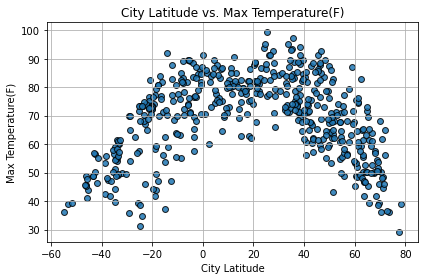

In [57]:
scatter_grid(df,'Lat','Max Temp','City Latitude','Max Temperature(F)')

## Latitude vs. Humidity Plot

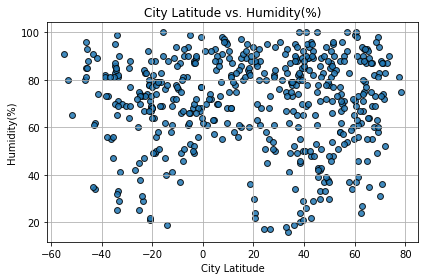

In [58]:
scatter_grid(df,'Lat','Humidity','City Latitude','Humidity(%)')

## Latitude vs. Cloudiness Plot

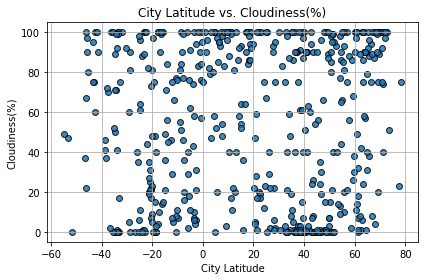

In [59]:
scatter_grid(df,'Lat','Cloudiness','City Latitude','Cloudiness(%)')

## Latitude vs. Wind Speed Plot

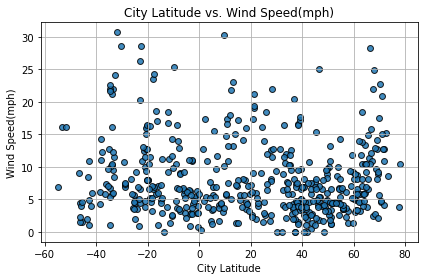

In [60]:
scatter_grid(df,'Lat','Wind Speed','City Latitude','Wind Speed(mph)')

## Linear Regression

In [41]:
north_df=df.loc[df["Lat"]>0]
south_df=df.loc[df["Lat"]<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is -0.6489588234170315


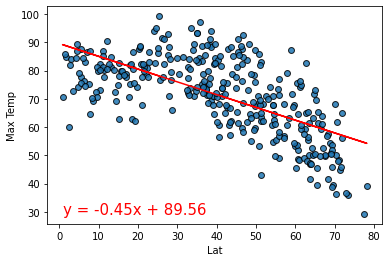

In [65]:
scatter_linereg(north_df,'Lat','Max Temp','City Latitude(North)','Temperature(F)')

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is 0.7109999054127575


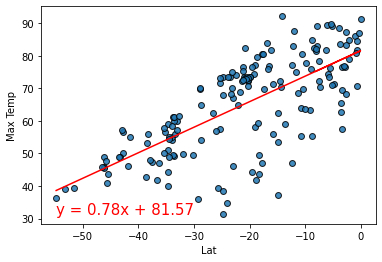

In [66]:
scatter_linereg(south_df,'Lat','Max Temp','City Latitude(South)','Temperature(F)')

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is -0.08779210822804379


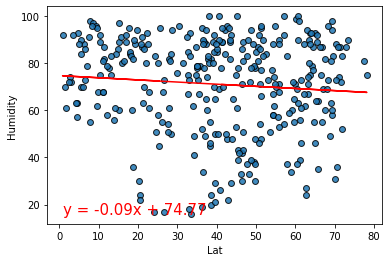

In [67]:
scatter_linereg(north_df,'Lat','Humidity','City Latitude(North)','Humidity(%)')

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is -0.019083738617038343


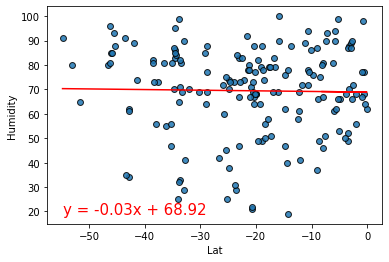

In [68]:
scatter_linereg(south_df,'Lat','Humidity','City Latitude(South)','Humidity(%)')

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is -0.018501941995828188


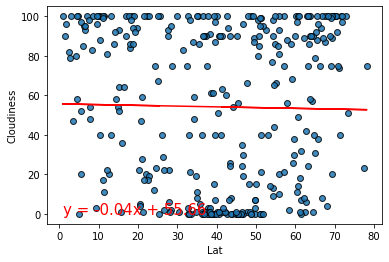

In [69]:
scatter_linereg(north_df,'Lat','Cloudiness','City Latitude(North)','Cloudiness(%)')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is -0.06377225686874255


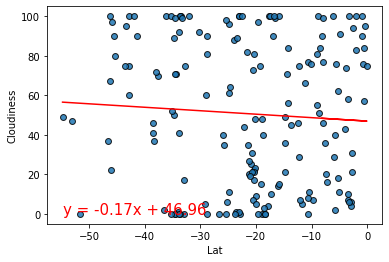

In [70]:
scatter_linereg(south_df,'Lat','Cloudiness','City Latitude(South)','Cloudiness(%)')

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is 0.008131254880444952


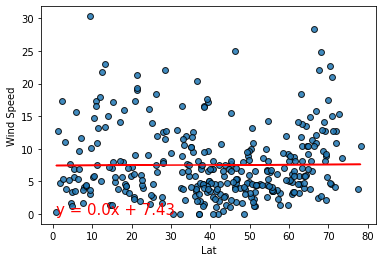

In [71]:
scatter_linereg(north_df,'Lat','Wind Speed','City Latitude(North)','Wind Speed(mph)')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is -0.15821866145113894


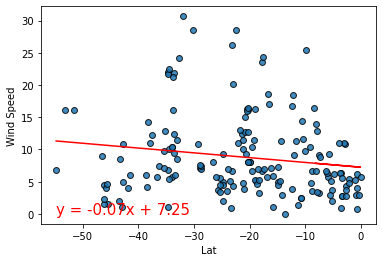

In [72]:
scatter_linereg(south_df,'Lat','Wind Speed','City Latitude(South)','Wind Speed(mph)')